In [2]:
import numpy as np
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

from platform import python_version

%matplotlib inline

np.__version__, python_version()

('1.18.5', '3.8.3')

# 1.

In [105]:
def get_bayer_masks(n_rows, n_cols):
    bayer = np.zeros((n_rows, n_cols, 3), 'bool')
    bayer[::2, 1::2, 0] = 1  # Red
    bayer[::2, ::2, 1] = 1   # Green
    bayer[1::2, 1::2, 1] = 1 # Green
    bayer[1::2, ::2, 2] = 1  # Blue
    return bayer

In [108]:
get_bayer_masks(2,2)

array([[[False,  True, False],
        [ True, False, False]],

       [[False, False,  True],
        [False,  True, False]]])

# 2.

In [124]:
def get_colored_img(raw_img):
    mask = get_bayer_masks(*raw_img.shape)
    return np.dstack([raw_img * mask[...,i] for i in range(3)])

In [126]:
img = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype='uint8')
get_colored_img(img)[...,0]

array([[0, 2, 0],
       [0, 0, 0],
       [0, 8, 0]], dtype=uint8)

# 3.

In [642]:
# too slow for images (3 min vs. 1 min limit)
#
# def bilinear_interpolation(colored_img):
#     interpolation = np.zeros(colored_img.shape, 'uint8')
#     mask = get_bayer_masks(*colored_img.shape[:2])
#     masked = np.ma.array(colored_img, mask=~mask)
#     w, h, dim = colored_img.shape
#     for c in range(dim):
#         for i in range(w):
#             for j in range(h):
#                 if not mask[i,j,c]:  
#                     # for "unknown" - use "known" values and take a mean
#                     interpolation[i,j,c] = masked[max(i-1,0):min(i+2,w),
#                                                   max(j-1,0):min(j+2,h), 
#                                                   c].mean()
#     return colored_img + interpolation

In [767]:
from scipy.signal import convolve2d

def bilinear_interpolation(colored_img):
    w, h, dim = colored_img.shape
    mask = get_bayer_masks(w, h)
    kernel = np.ones((3, 3))
    for c in range(dim):
        conv = (convolve2d(colored_img[...,c], kernel, mode='same') / \
                convolve2d(mask[...,c], kernel, mode='same')).astype('uint8')
        conv[mask[...,c]] = 0
        colored_img[...,c] += conv
    return colored_img

In [768]:
raw_img = np.array([[202, 150, 137, 121, 195],
                 [ 94,   0, 217,  68, 248],
                 [208, 170, 109,  67,  22],
                 [ 20,  93, 222,  54,  50],
                 [254, 252,  10, 187, 203]], dtype='uint8')
colored_img = get_colored_img(raw_img)
gt_img = np.zeros((5, 5, 3), 'uint8')
r = slice(1, -1), slice(1, -1)
gt_img[r + (0,)] = np.array([[160, 127,  94],
                          [170, 118,  67],
                          [211, 169, 127]])
gt_img[r + (1,)] = np.array([[  0,  78,  68],
                          [102, 109,  63],
                          [ 93,  66,  54]])
gt_img[r + (2,)] = np.array([[155, 217, 232],
                          [138, 219, 184],
                          [121, 222, 136]])

img = img_as_ubyte(bilinear_interpolation(colored_img))

(img[r]-gt_img[r] == 0).all()

True

# 4.

In [769]:
def improved_interpolation(raw_img):
    '''
    Inspired by and adjusted implementation:
    https://github.com/colour-science/colour-demosaicing/blob/master/colour_demosaicing/bayer/demosaicing/malvar2004.py
    '''
    # G at R locations / G at B locations
    GR_GB = np.array([[0.0, 0.0, -1.0, 0.0, 0.0],
                       [0.0, 0.0, 2.0, 0.0, 0.0],
                       [-1.0, 2.0, 4.0, 2.0, -1.0],
                       [0.0, 0.0, 2.0, 0.0, 0.0],
                       [0.0, 0.0, -1.0, 0.0, 0.0]]) / 8

    # R at green in R row, B column / B at green in B row, R column
    Rg_RB_Bg_BR = np.array([[0.0, 0.0, 0.5, 0.0, 0.0],
                            [0.0, -1.0, 0.0, -1.0, 0.0],
                            [-1.0, 4.0, 5.0, 4.0, -1.0],
                            [0.0, -1.0, 0.0, -1.0, 0.0],
                            [0.0, 0.0, 0.5, 0.0, 0.0]]) / 8
    
    # R at green in B row, R column / B at green in R row, B column
    Rg_BR_Bg_RB = Rg_RB_Bg_BR.T

    # R at blue in B row, B column / B at red in R row, R column 
    Rb_BB_Br_RR = np.array([[0.0, 0.0, -1.5, 0.0, 0.0],
                            [0.0, 2.0, 0.0, 2.0, 0.0],
                            [-1.5, 0.0, 6.0, 0.0, -1.5],
                            [0.0, 2.0, 0.0, 2.0, 0.0],
                            [0.0, 0.0, -1.5, 0.0, 0.0]]) / 8
    
    raw_img = raw_img.astype(np.float64)
    colored_img = get_colored_img(raw_img)
    w, h, dim = colored_img.shape
    mask = get_bayer_masks(w, h)
    
    R, G, B = [colored_img[...,i] for i in range(3)]
    R_mask, G_mask, B_mask = [mask[...,i] for i in range(3)]
    
    G = np.where(np.logical_or(R_mask == 1, B_mask == 1), convolve2d(raw_img, GR_GB, mode='same'), G)
    
    RBg_RBBR = convolve2d(raw_img, Rg_RB_Bg_BR, mode='same')
    RBg_BRRB = convolve2d(raw_img, Rg_BR_Bg_RB, mode='same')
    RBgr_BBRR = convolve2d(raw_img, Rb_BB_Br_RR, mode='same')
    
    R_rows = np.transpose(np.any(R_mask == 1, axis=1)[np.newaxis]) * np.ones(R.shape)
    R_columns = np.any(R_mask == 1, axis=0)[np.newaxis] * np.ones(R.shape)
    B_rows = np.transpose(np.any(B_mask == 1, axis=1)[np.newaxis]) * np.ones(B.shape)
    B_columns = np.any(B_mask == 1, axis=0)[np.newaxis] * np.ones(B.shape)

    R = np.where(np.logical_and(R_rows == 1, B_columns == 1), RBg_RBBR, R)
    R = np.where(np.logical_and(B_rows == 1, R_columns == 1), RBg_BRRB, R)
    B = np.where(np.logical_and(B_rows == 1, R_columns == 1), RBg_RBBR, B)
    B = np.where(np.logical_and(R_rows == 1, B_columns == 1), RBg_BRRB, B)
    R = np.where(np.logical_and(B_rows == 1, B_columns == 1), RBgr_BBRR, R)
    B = np.where(np.logical_and(R_rows == 1, R_columns == 1), RBgr_BBRR, B)
        
    result = np.clip(np.dstack([R, G, B]), 0, 255)
    return result.astype('uint8')

In [770]:
raw_img = np.array([[8, 5, 3, 7, 1, 3],
                     [5, 2, 6, 8, 8, 1],
                     [9, 9, 8, 1, 6, 4],
                     [9, 4, 2, 3, 6, 8],
                     [5, 4, 3, 2, 8, 7],
                     [7, 3, 3, 6, 9, 3]], dtype='uint8')

gt_img = np.zeros((6, 6, 3), 'uint8')
r = slice(2, -2), slice(2, -2)
gt_img[r + (0,)] = np.array([[6, 1],
                          [1, 0]])
gt_img[r + (1,)] = np.array([[8, 4],
                          [2, 3]])
gt_img[r + (2,)] = np.array([[7, 2],
                          [2, 2]])
img = img_as_ubyte(improved_interpolation(raw_img))
(img[r] - gt_img[r] == 0).all()

True

# 5.

In [771]:
def compute_psnr(img_pred, img_gt):
    w, h, c = img_pred.shape
    pred = img_pred.astype(np.float64)
    gt = img_gt.astype(np.float64)
    MSE = np.sum((pred - gt)**2) / (c*h*w)
    if MSE == 0:
        raise ValueError
    PSNR = 10*np.log10(np.max(gt)**2 / MSE)
    return PSNR

# test

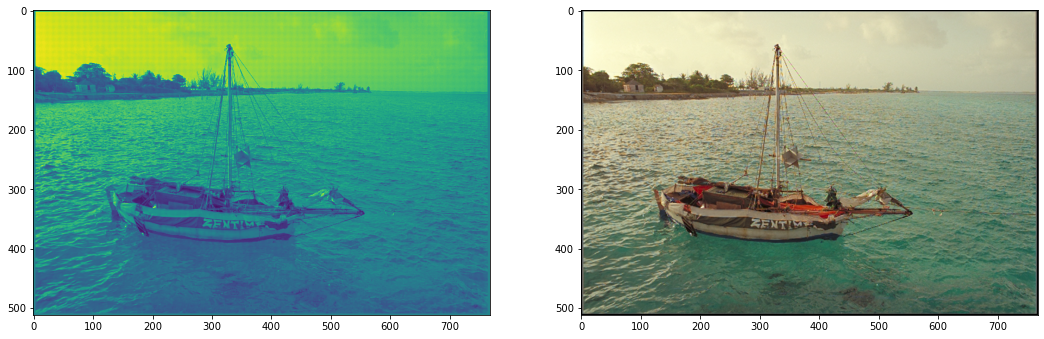

In [806]:
image = imread('tests/06_unittest_improved_img_input/03.png')
image_gt = imread('tests/06_unittest_improved_img_input/gt_03.png')

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image_gt)

In [807]:
img_pred_bilinear = img_as_ubyte(bilinear_interpolation(get_colored_img(image)))
img_pred_improved = img_as_ubyte(improved_interpolation(image))

compute_psnr(img_pred_bilinear, image_gt), compute_psnr(img_pred_improved, image_gt)

(24.521314406774547, 25.685337495983752)

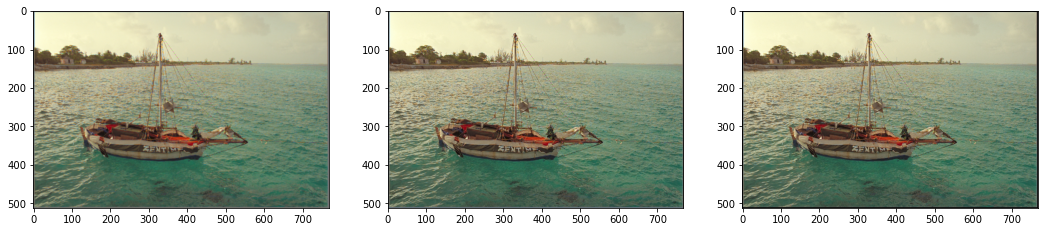

In [812]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(img_pred_bilinear)
plt.subplot(1, 3, 2)
plt.imshow(img_pred_improved)
plt.subplot(1, 3, 3)
plt.imshow(image_gt)

* __improved__ is better (25.68 > 24.52)